In [1]:
import magnonRPA as rpa
import numpy as np

from matplotlib import pyplot as plt 
from matplotlib import colors as mclr
from matplotlib import colormaps as cmaps

import time

### Plotting settings 
#plt.rc('figure', dpi=100)
#plt.rc('figure',figsize=(4,1.7))
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

saveFigs = False ### Option to save figures or not 

figDirectory = "../figures/06022025/" ### Figures are stored in this folder
dataDirectory = "../data/" ### Data is loaded from and stored to this folder


## Load in spectral function

In [2]:
holesDirectory = dataDirectory+"hole_spectra/05052025/5ksamples/" 
holesFile = holesDirectory+"jon_request_0.5" 
Jh = 0.5

f_spec = rpa.fermion_spectra()
f_spec.load_hole_spectrum(holesFile)

In [15]:
mus = np.linspace(-2.*rpa.t,6.*rpa.t,100)
Ts = np.array([0.001*rpa.t,0.05*rpa.t,0.1*rpa.t,0.15*rpa.t])
f_spec.calc_doping(mus,Ts)

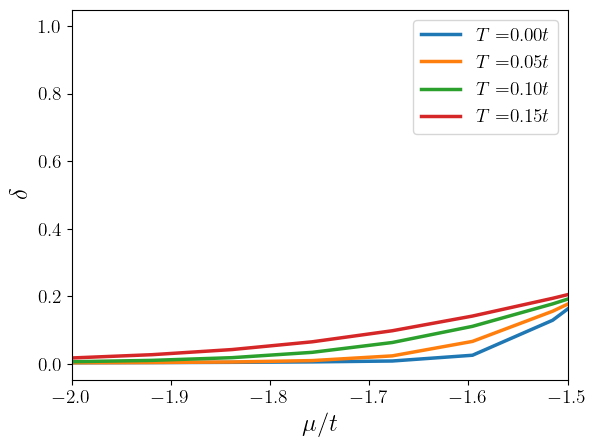

In [19]:
for i in range(len(Ts)):
    plt.plot(f_spec.mus,f_spec.dopings[:,i],label=r'$T = ${T:0.2f}$t$'.format(T=Ts[i]))
plt.xlabel(r'$\mu/t$')
plt.ylabel(r'$\delta$')
plt.legend()
plt.xlim(-2.,-1.5)
plt.show()

In [329]:
### Location of hole spectral functions
Jh = 0.05
holesDirectory = dataDirectory+"hole_spectra/05052025/5ksamples/" 
holesFile = holesDirectory+"jon_request_0.5" 

### Load in spectral function
kxs,kys,ws,A = rpa.load_hole_spectrum(holesFile)
### If this is true we will use a fictious box spectral function
useBox = False
useSemicircle = False

if useBox:
    W = 2.*rpa.t
    Nkx = 40
    Nky = 40
    Nw = 1001
    
    kxs = np.linspace(0.,2.*np.pi,Nkx,endpoint=False)
    kys = np.linspace(0.,2.*np.pi,Nky,endpoint=False)
    ws = np.linspace(-10.,10.,Nw)
    A = rpa.gen_box_A(kxs,kys,ws,W)


if useSemicircle:
    W = 4.*rpa.t
    Nkx = 40
    Nky = 40
    Nw = 1001
    
    kxs = np.linspace(0.,2.*np.pi,Nkx,endpoint=False)
    kys = np.linspace(0.,2.*np.pi,Nky,endpoint=False)
    ws = np.linspace(-10.,10.,Nw)
    A = rpa.gen_semicircle_A(kxs,kys,ws,W)

    
### Useful to make vectorized grids and keep track of sizes of arrays
kxvs,kyvs,wvs = np.meshgrid(kxs,kys,ws)
Nkx = len(kxs)
Nky = len(kys)
Nw = len(ws)
dw = ws[1]-ws[0]
print("Nkx,Nky,Nw: ", Nkx,Nky,Nw)
print("dw: ",dw)

KK_matrix = rpa.KK_matrix(ws)

Nkx,Nky,Nw:  40 40 5000
dw:  0.004000800160032014


## Plot hole spectrum

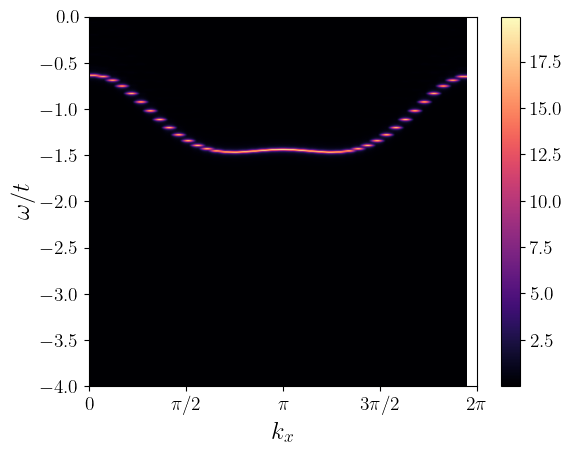

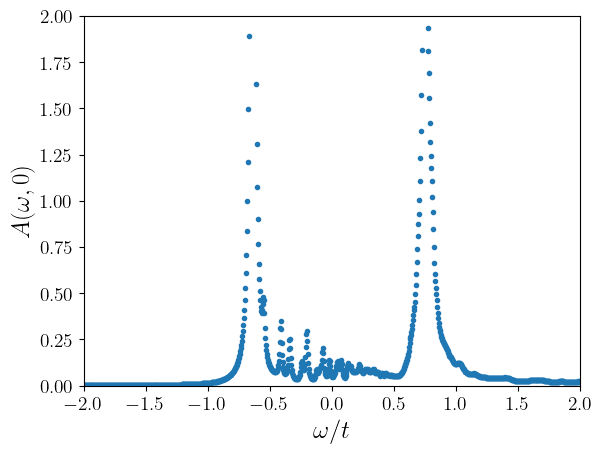

0.9995468721157156


In [330]:
### Plot spectral function for a cut
plt.imshow(np.transpose(A[:,0,:]),extent=[kxs[0],kxs[-1],ws[0],ws[-1]],origin='lower',cmap='magma',aspect=1.5)
plt.colorbar()
plt.ylim(-4.*rpa.t,-0.*rpa.t)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$\omega/t$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
if saveFigs: plt.savefig(figDirectory+"/hole_spectrum_Jh=0.5.png",bbox_inches='tight',transparent=True)
plt.show()

plt.plot(ws/rpa.t,A[0,0,:],'.')
plt.ylabel(r'$A(\omega,0)$')
plt.xlabel(r'$\omega/t$')
plt.xlim(-2,2)
plt.ylim(0.,2)
plt.show()
print(np.sum(A)*dw/float(Nkx*Nky))

## Set parameters and computing doping

In [391]:
T = 0.01*rpa.t ### temperature
U = 8.*rpa.t ### Hubbard U (used to compute J)
J = 4.*rpa.t**2/U ### Superexchange J
mu = -1.583*rpa.t ### Chemical potential (controls doping)


### Compute doping
delta = rpa.calc_density(kxs,kys,ws,A,mu,T)
print("Hole doping: {d:0.2%}".format(d=delta))
print("J/t used in LSWT: {jt:0.2f}".format(jt=J/rpa.t))

Hole doping: 4.00%
J/t used in LSWT: 0.50


## Now we compute the RPA kernel and magnon propagator

In [392]:
### Calculate RPA spectra from hole spectra 
t0 = time.time()

ImPi = rpa.calc_ImPi(kxs,kys,ws,A,mu,T)

t1 = time.time()

Pi = rpa.Kramers_Kronig_precomputed(KK_matrix,ImPi)

t2 = time.time()


print("Time for RPA: ",t1-t0,"s")
print("Time for Kramers-Kronig: ",t2-t1,"s")

Time for RPA:  44.191102027893066 s
Time for Kramers-Kronig:  14.40037989616394 s


In [393]:
t2 = time.time()

magnon_kernel=rpa.RPA_kernel(kxs,kys,ws,Pi,J)
magnon_propagator = rpa.RPA_propagator_analytic(kxs,kys,ws,Pi,J)

t3 = time.time()

spectrum = rpa.RPA_spectrum(kxs,kys,ws,magnon_propagator)

t4 = time.time()

sum_rule = np.sum(spectrum,axis=-1)*dw 
print("Time for forming and inverting kernel: ",t3-t2,"s")
print("Time for computing spectrum: ",t4-t3,"s")


Time for forming and inverting kernel:  5.73960280418396 s
Time for computing spectrum:  0.05557394027709961 s


## Plotting and various diagonostics

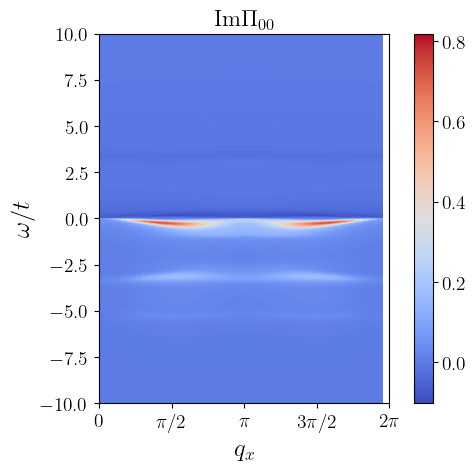

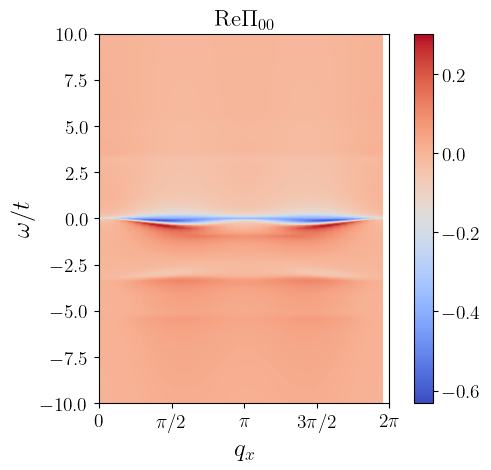

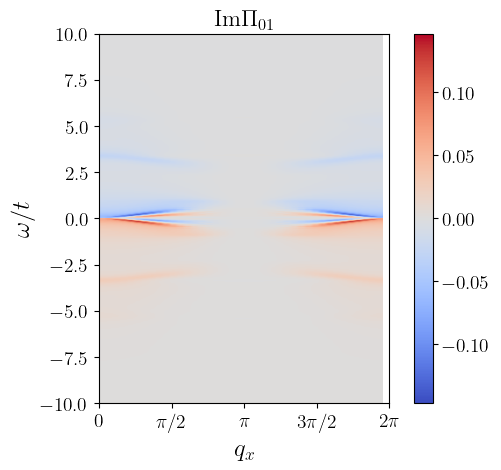

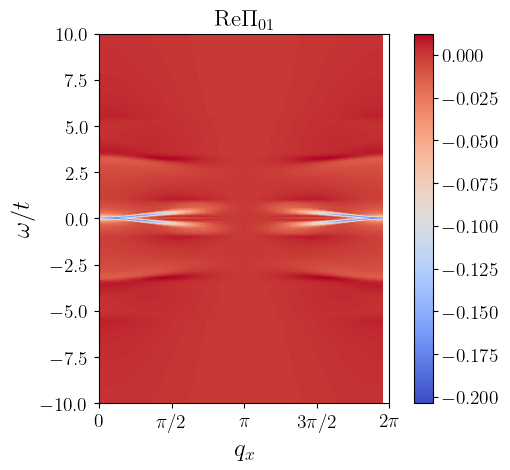

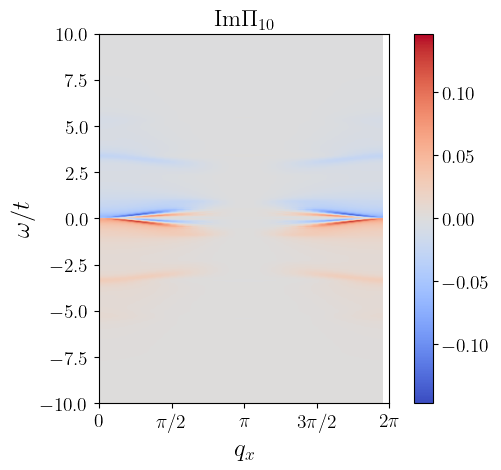

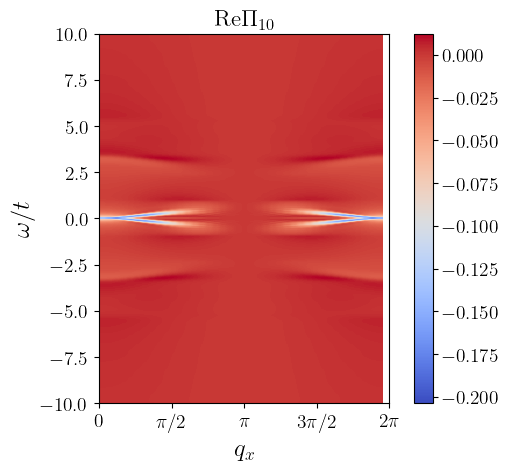

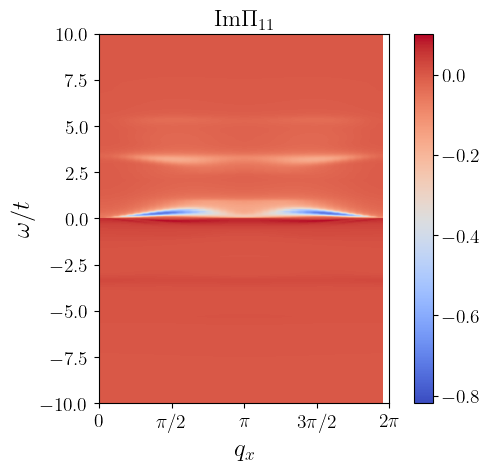

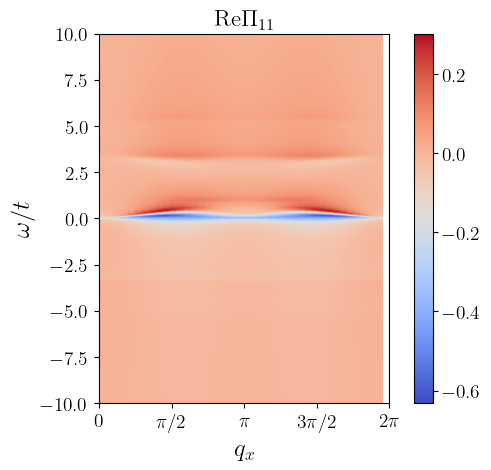

In [394]:
### Frequency dependence of Pi for kx cut 
labels = [ [ r'$\Pi_{00}$',r'$\Pi_{01}$'],[ r'$\Pi_{10}$',r'$\Pi_{11}$'] ] 
for i in range(2):
    for j in range(2):
        plt.imshow(np.transpose(np.imag(Pi[i,j,:,0,:])),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
        plt.xlabel(r'$q_x$')
        plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
        plt.ylabel(r'$\omega/t$')
        plt.colorbar()
        plt.title(r'Im'+labels[i][j])
        plt.show()
        
        plt.imshow(np.transpose(np.real(Pi[i,j,:,0,:])),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
        plt.xlabel(r'$q_x$')
        plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
        plt.ylabel(r'$\omega/t$')
        plt.colorbar()
        plt.title(r'Re'+labels[i][j])
        plt.show()

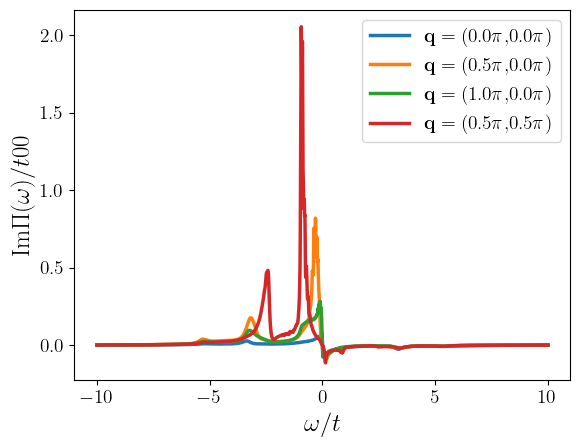

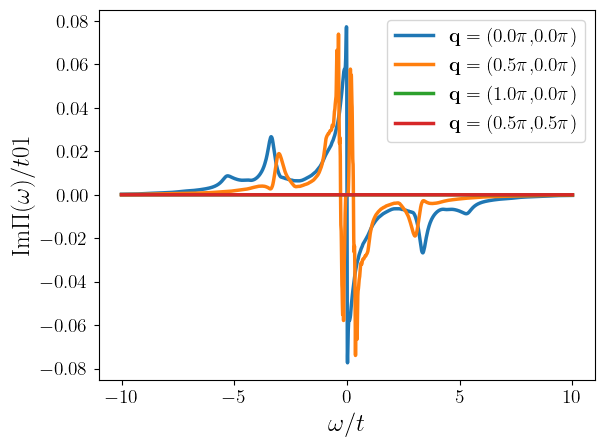

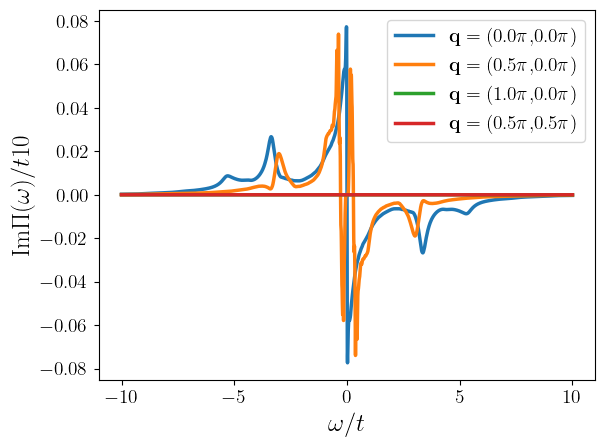

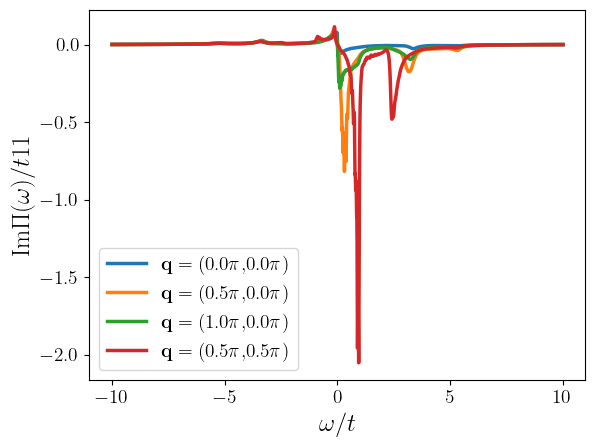

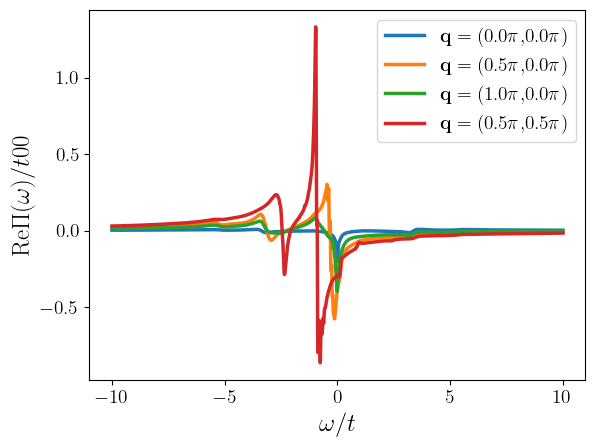

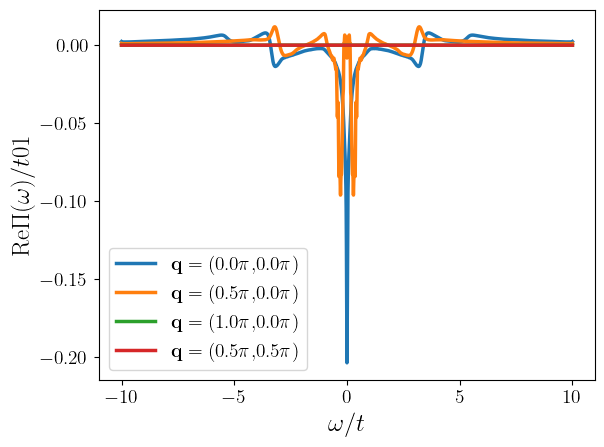

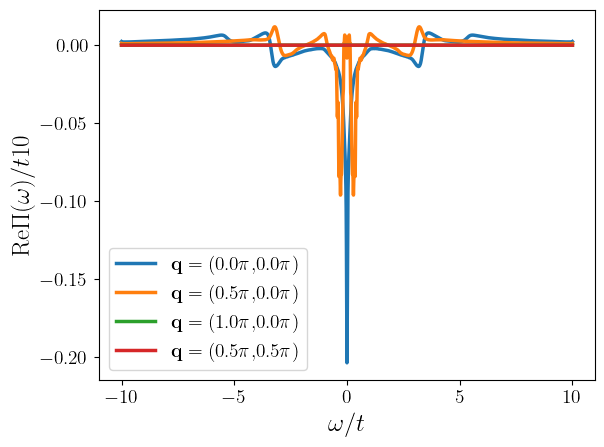

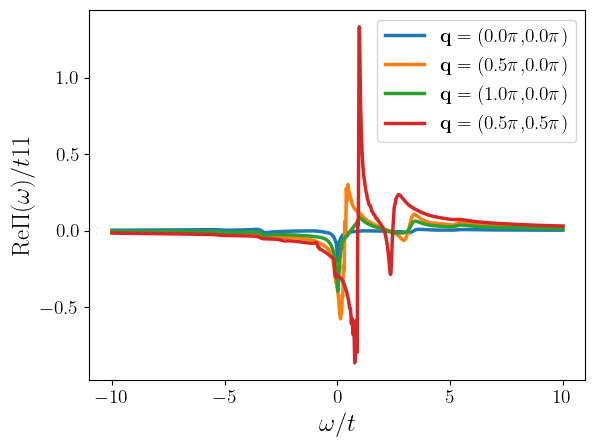

In [395]:
### Spectral function frequency cuts
indices = [[0,0],[10,0],[20,0],[10,10]]
#clrs = cmaps['magma'](np.linspace(0.,0.7,len(indices)))
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]

for a in range(2):
    for b in range(2):
        for j in range(len(indices)):
            i = indices[j]
            plt.plot(rpa.gen_magnon_freqs(ws)/rpa.t, np.imag(Pi[a,b,i[0],i[1],:])/rpa.t,label=label_strings[j])#,color=clrs[j])
        plt.xlabel(r'$\omega/t$')
        plt.ylabel(r'Im$\Pi(\omega)/t$'+str(a)+str(b))
        plt.legend()
        if saveFigs: plt.savefig(figDirectory+"/ImPi"+str(a)+str(b)+"_Jh=0.5_"+"delta={d:0.1%}_T={t:0.2f}.png".format(d=delta,t=T),bbox_inches='tight',transparent=True)
        plt.show()

for a in range(2):
    for b in range(2):
        for j in range(len(indices)):
            i = indices[j]
            plt.plot(rpa.gen_magnon_freqs(ws)/rpa.t, np.real(Pi[a,b,i[0],i[1],:])/rpa.t,label=label_strings[j])#,color=clrs[j])
        plt.xlabel(r'$\omega/t$')
        plt.ylabel(r'Re$\Pi(\omega)/t$'+str(a)+str(b))
        plt.legend()
        if saveFigs: plt.savefig(figDirectory+"/RePi"+str(a)+str(b)+"_Jh=0.5_"+"delta={d:0.1%}_T={t:0.2f}.png".format(d=delta,t=T),bbox_inches='tight',transparent=True)
        plt.show()

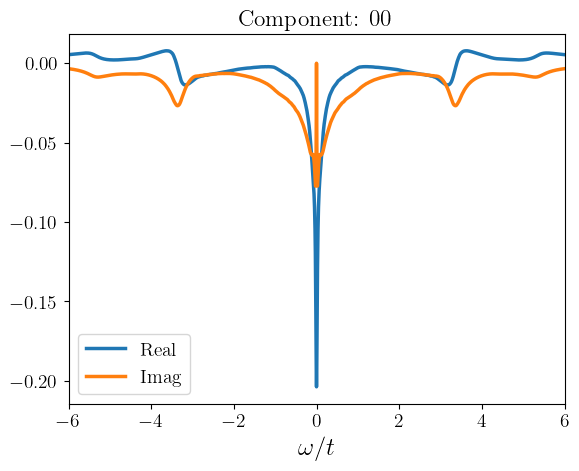

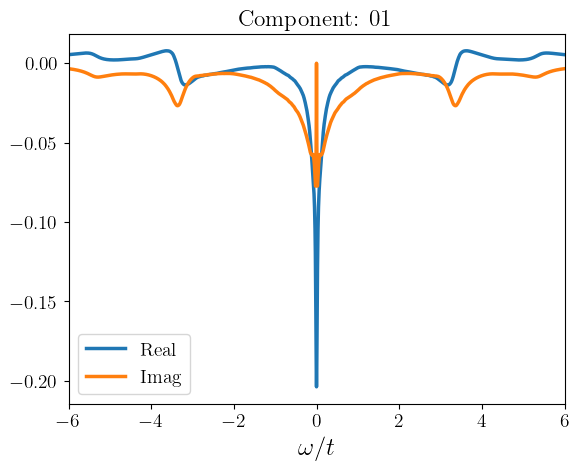

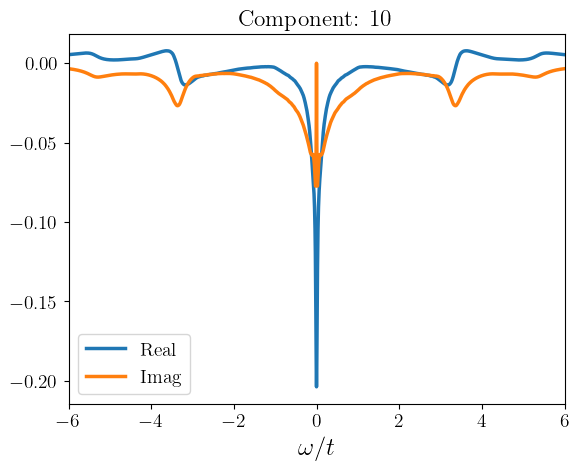

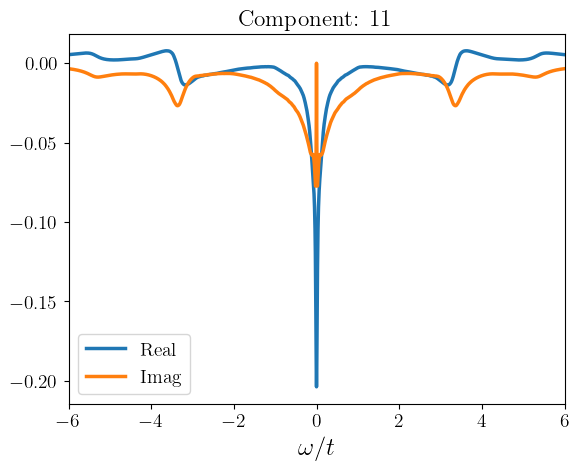

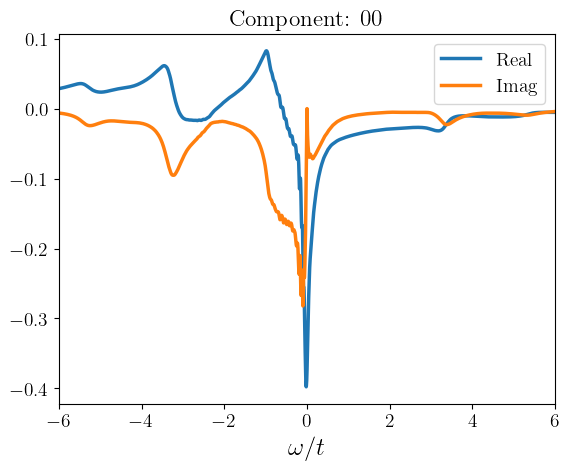

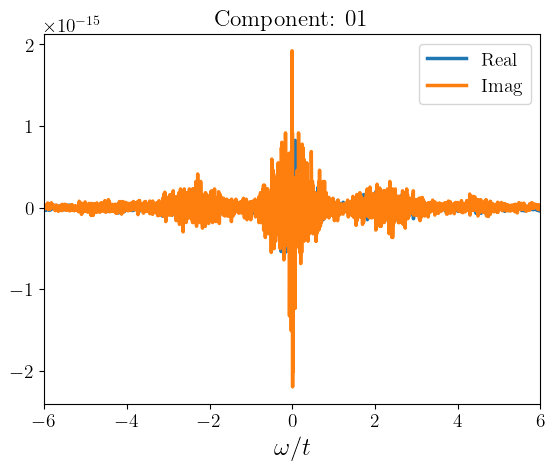

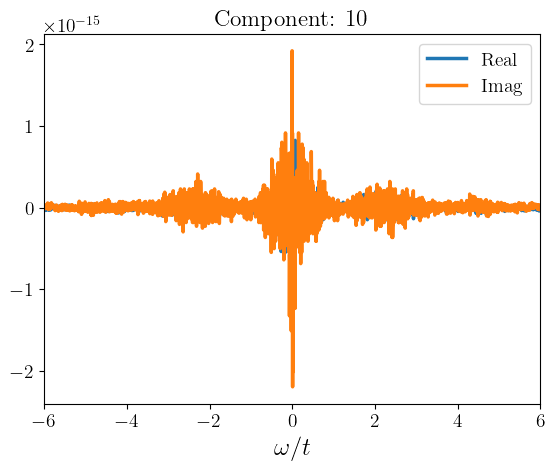

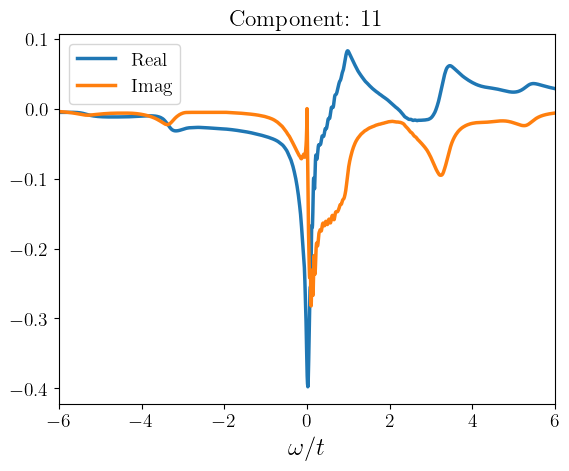

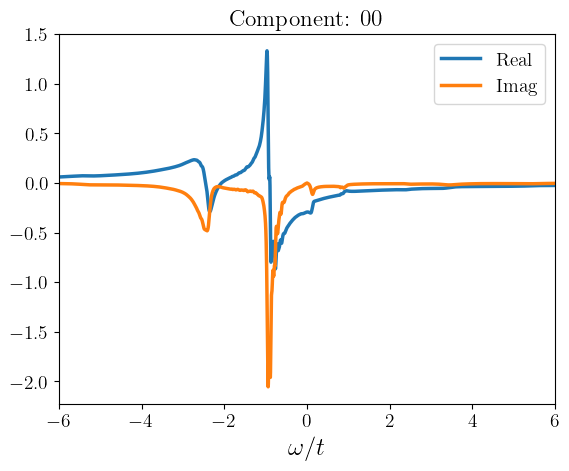

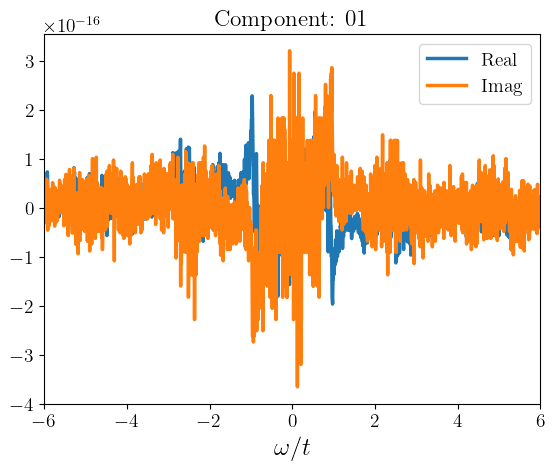

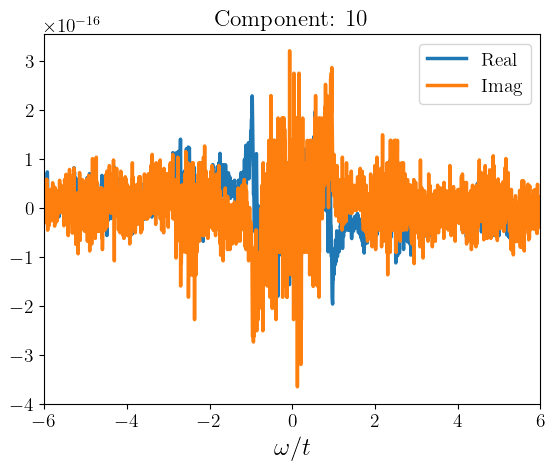

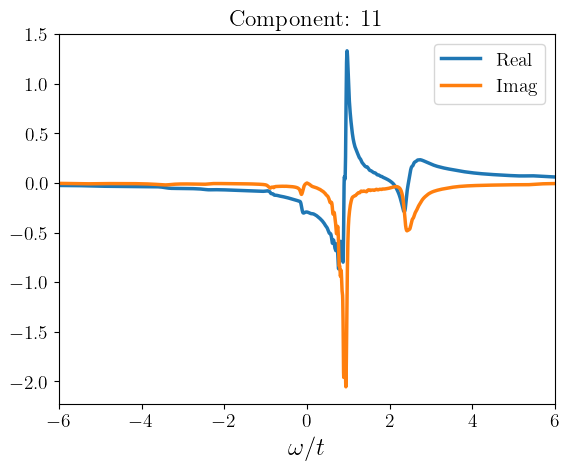

In [405]:
### Spectral function frequency cuts
indices = [[0,0],[20,0],[10,10]]
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]
for j in range(len(indices)):
    i = indices[j]
    for a in range(2):
        for b in range(2):
            plt.plot(rpa.gen_magnon_freqs(ws)/rpa.t, np.real(Pi[a,b,i[0],i[1],:])/rpa.t,label="Real")
            plt.plot(rpa.gen_magnon_freqs(ws)/rpa.t, np.sign(rpa.gen_magnon_freqs(ws))*np.imag(Pi[a,b,i[0],i[1],:])/rpa.t,label="Imag")
            plt.xlabel(r'$\omega/t$')
            plt.xlim(-6,6)
            plt.title("Component: "+str(a)+str(b))
            plt.legend()
    
            plt.show()

0.0 0.0
0.9994977808460588
0.25 0.0
0.9803572084354722
0.5 0.0
1.0002506660534924
1.0 0.0
0.9996287135620759
0.5 0.5
0.9966894242942007


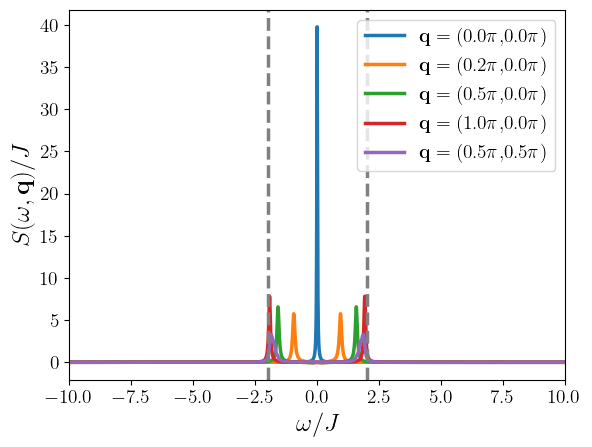

In [396]:
### Spectral function frequency cuts

indices = [[0,0],[5,0],[10,0],[20,0],[10,10]]
#clrs = cmaps['magma'](np.linspace(0.,0.7,len(indices)))
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]

for j in range(len(indices)):
    i = indices[j]
    print(kxs[i[0]]/np.pi,kys[i[1]]/np.pi)
    print(np.sum(spectrum[i[0],i[1],:])*dw)
    plt.plot(rpa.gen_magnon_freqs(ws)/J, spectrum[i[0],i[1],:],label=label_strings[j])
plt.axvline(2.,linestyle='dashed',color='gray')
plt.axvline(-2.,linestyle='dashed',color='gray')
plt.xlabel(r'$\omega/J$')
plt.ylabel(r'$S(\omega,\mathbf{q})/J$')
plt.legend()
plt.xlim(-10.,10.)
#plt.yscale('log')
plt.show()


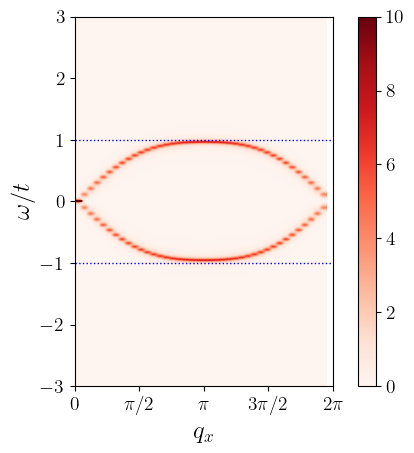

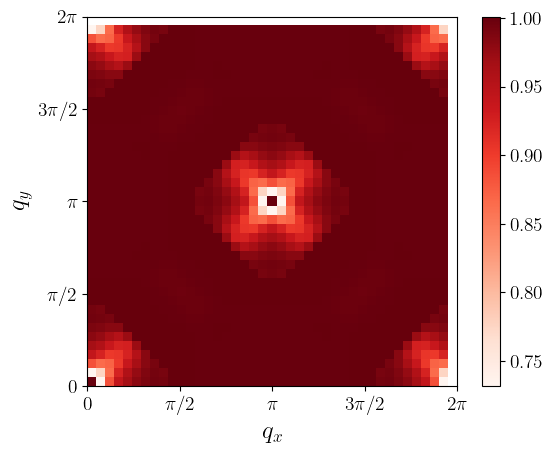

In [397]:
scale = mclr.LogNorm()
scale = mclr.Normalize(0.,10.)
plt.imshow(np.transpose(spectrum[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],cmap='Reds',aspect=1.5,norm=scale)
plt.ylabel(r'$\omega/t$')
plt.ylim(-3,3)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#plt.title(r'$\delta = $'+"{:0.1%}".format(delta)+r'$T/t = $'+"{:0.2f}".format(T))
plt.axhline(2.*J,linestyle='dotted',color='blue',linewidth=1.)
plt.axhline(-2.*J,linestyle='dotted',color='blue',linewidth=1.)
if saveFigs: plt.savefig(figDirectory+"/spectrum_Jh=0.5_"+"delta={d:0.1%}_T={t:0.2f}.png".format(d=delta,t=T),bbox_inches='tight',transparent=True)
plt.show()

scale = mclr.Normalize(0.,1.)
scale=None
plt.imshow(np.transpose(np.sum(spectrum,axis=-1)*dw),origin='lower',extent=[kxs[0],kxs[-1],kys[0],kys[-1]],aspect=1,cmap='Reds',norm=scale)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.ylabel(r'$q_y$')
plt.yticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#plt.title(r'$\delta = $'+"{:0.1%}".format(delta))
if saveFigs: plt.savefig(figDirectory+"/sum_rule_Jh=0.5_"+"delta={d:0.1%}_T={t:0.2f}.png".format(d=delta,t=T),bbox_inches='tight',transparent=True)
plt.show()
